# Applying Machine Learning To Sentiment Analysis

# Obtaining the IMDb movie review dataset

In [2]:
import pandas as pd
import pyprind
import os
from __future__ import division

#### Code snippet for reading multiple text documents from diffenrent resources and joining them

In [33]:
basepath = '../../../aclImdb/'

labels = {'pos':1, 'neg':0}
pbar = pyprind.ProgBar(50000)
df = pd.DataFrame()

for s in ('test','train'):
    for l in ('pos', 'neg'):
        path = os.path.join(basepath,s,l)
        for file in os.listdir(path):
            with open(os.path.join(path,file), 'r') as infile:
                txt = infile.read()
            df = df.append([[txt, labels[l]]], ignore_index=True)
            pbar.update()
            break
        break
    break
df.columns = ['review', 'sentiment']

In [34]:
import numpy as np

# suffle the DataFrame
np.random.seed(0)
df = df.reindex(np.random.permutation(df.index)) 

In [35]:
# save the new csv file
df.to_csv('./movie_data1.csv', index=False)

In [36]:
df.iloc[0,0]

"I've watched a lot of television in my 51 years, but I've never had so much fun week after week, as I had watching Oz. The acting by the entire cast was excellent. The writing was just perfect, with every character remaining consistent throughout the six year run. I also enjoyed the mayhem and the ultra-violence. It may sound odd, but it was at times, comical finding out how one of the characters would eventually end up dead. I particularly enjoyed the true romance and love between Beecher and Keller. Those two men really knew how to throw down, in every way possible. I truly hope that HBO will continue to show us re-runs of this great show FOREVER! I've watched every episode at least 4 times yet I still look forward to Tuesday and Thursday nights at 11 p.m. for an episode of this fun and very entertaining show."

#### Import the data

In [37]:
df = pd.read_csv("../movie_data.csv")
df.head(3)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0


<br>
# Introducing the bag-of-words model

#### Transforming documents into feature vectors

In [28]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [29]:
count = CountVectorizer()
docs = np.array([
        'The sun is shining',
        'The weather is sweet',
        'The sun is shining, the weather is sweet, and one and one is two'
    ])
bag = count.fit_transform(docs)

In [30]:
count.vocabulary_

{u'and': 0,
 u'is': 1,
 u'one': 2,
 u'shining': 3,
 u'sun': 4,
 u'sweet': 5,
 u'the': 6,
 u'two': 7,
 u'weather': 8}

Raw term frequencies: tf (t,d)—the number of times a term t occurs in a document d.

In [31]:
# raw term frequencies
bag.toarray()

array([[0, 1, 0, 1, 1, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 1, 1, 0, 1],
       [2, 3, 2, 1, 1, 1, 2, 1, 1]])

#### Assessing word relevancy via term frequency-inverse document frequency

$$\text{tf-idf}(t,d)=\text{tf (t,d)}\times \text{idf}(t,d)$$


$$\text{idf}(t,d) = \text{log}\frac{n_d}{1+\text{df}(d, t)},$$

In [41]:
np.set_printoptions(precision=2)

In [42]:
from sklearn.feature_extraction.text import TfidfTransformer

In [44]:
# TfidfTransformer, that takes the raw term frequencies from CountVectorizer as input and transforms them into tf-idfs
tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)
print(tfidf.fit_transform(bag).toarray())

[[ 0.    0.43  0.    0.56  0.56  0.    0.43  0.    0.  ]
 [ 0.    0.43  0.    0.    0.    0.56  0.43  0.    0.56]
 [ 0.5   0.45  0.5   0.19  0.19  0.19  0.3   0.25  0.19]]


The equations for the idf and tf-idf that were implemented in scikit-learn are:

$$\text{idf} (t,d) = log\frac{1 + n_d}{1 + \text{df}(d, t)}$$

The tf-idf equation that was implemented in scikit-learn is as follows:

$$\text{tf-idf}(t,d) = \text{tf}(t,d) \times (\text{idf}(t,d)+1)$$

While it is also more typical to normalize the raw term frequencies before calculating the tf-idfs, the `TfidfTransformer` normalizes the tf-idfs directly.

By default (`norm='l2'`), scikit-learn's TfidfTransformer applies the L2-normalization, which returns a vector of length 1 by dividing an un-normalized feature vector *v* by its L2-norm:

$$v_{\text{norm}} = \frac{v}{||v||_2} = \frac{v}{\sqrt{v_{1}^{2} + v_{2}^{2} + \dots + v_{n}^{2}}} = \frac{v}{\big (\sum_{i=1}^{n} v_{i}^{2}\big)^\frac{1}{2}}$$


In [24]:
# calculate tf-idf for "is"
tf_is = 3
n_docs = 3
idf_is = np.log((n_docs+1)/(3+1))
tfidf_is = tf_is * (idf_is+1)
tfidf_is

3.0

In [22]:
# tf-idf vector
tfidf = TfidfTransformer(use_idf=True, norm=None, smooth_idf=True)
raw_input = tfidf.fit_transform(bag).toarray()[-1]
raw_input

array([ 3.39,  3.  ,  3.39,  1.29,  1.29,  1.29,  2.  ,  1.69,  1.29])

$$\text{tfi-df}_{norm} = \frac{[3.39, 3.0, 3.39, 1.29, 1.29, 1.29, 2.0 , 1.69, 1.29]}{\sqrt{[3.39^2, 3.0^2, 3.39^2, 1.29^2, 1.29^2, 1.29^2, 2.0^2 , 1.69^2, 1.29^2]}}$$

$$=[0.5, 0.45, 0.5, 0.19, 0.19, 0.19, 0.3, 0.25, 0.19]$$

$$\Rightarrow \text{tfi-df}_{norm}("is", d3) = 0.45$$

In [20]:
# l2 normalization
l2_tfidf = raw_input/np.sqrt(np.sum(raw_input**2))
l2_tfidf

array([ 0.5 ,  0.45,  0.5 ,  0.19,  0.19,  0.19,  0.3 ,  0.25,  0.19])

## Cleaning text data

In [46]:
# the data includes html markups that needs to be cleaned
df.loc[0,'review'][-50:]

'is seven.<br /><br />Title (Brazil): Not Available'

In [58]:
import re

def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-','')
    return text

In [59]:
preprocessor(df.loc[0,'review'][-50:])

'is seven title brazil not available'

In [60]:
preprocessor("</a>This :) is :( a test :-)!")

'this is a test :) :( :)'

In [61]:
df['review'] = df['review'].apply(preprocessor)

## Processing documents into tokens

In [67]:
from nltk.stem.porter import PorterStemmer

In [80]:
porter = PorterStemmer()

def tokenizer(text):
    return text.split()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [81]:
w = 'runners like runnign so they run'
tokenizer_porter(w)

[u'runner', u'like', u'runnign', u'so', u'they', u'run']

In [82]:
tokenizer(w)

['runners', 'like', 'runnign', 'so', 'they', 'run']

In [83]:
import nltk

In [84]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/samet/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [85]:
from nltk.corpus import stopwords

In [95]:
stop = stopwords.words('english')
[w for w in tokenizer_porter('a runner likes running and run a lot') if w not in stop]

[u'runner', u'like', u'run', u'run', u'lot']

<br>
# Training a logistic regression model for document classification

In [102]:
X_train = df.loc[:25000,'review'].values
y_train = df.loc[:25000,'sentiment'].values
X_test = df.loc[25000:,'review'].values
y_test = df.loc[25000:,'sentiment'].values

In [103]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

In [104]:
tfidf = TfidfVectorizer(strip_accents=None,
                       lowercase=None,
                       preprocessor=None)
# try with/witout stopwords
# second dictionary is without idf and normalization to train a model with raw frequencies
param_grid = [{'vect__ngram_range': [(1,1)],
              'vect__stop_words': [stop, None],
              'vect__tokenizer': [tokenizer,tokenizer_porter],
              'clf__penalty': ['l1','l2'],
              'clf__C' : [1.0, 10.0, 100.0]},
             {'vect__ngram_range': [(1,1)],
              'vect__stop_words': [stop, None],
              'vect__tokenizer': [tokenizer,tokenizer_porter],
              'vect__use_idf': [False],
              'vect__norm': [None],
              'clf__penalty': ['l1','l2'],
              'clf__C': [1.0, 10.0, 100.0]}]

lr_tfidf = Pipeline([('vect', tfidf),
                   ('clf', LogisticRegression(random_state=0))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                          scoring='accuracy',
                          cv=5,
                          verbose=1,
                          n_jobs=-1)

In [107]:
# takes 40 min to train!
# gs_lr_tfidf.fit(X_train, y_train)

    > print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
    > print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)

    Best parameter set: {'vect__tokenizer': <function tokenizer at 0x11851c6a8>, 'clf__C': 10.0, 'vect__stop_words': None, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1)} 
    CV Accuracy: 0.897


    > clf = gs_lr_tfidf.best_estimator_
    > print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

    Test Accuracy: 0.899

<hr>

#### Illustrating gs_lr_tfidf.best_score_ is the average k-fold cross-validation score. 
If we have a GridSearchCV object with 5-fold cross-validation (like the one above), the best_score_ attribute returns the average score over the 5-folds of the best model. To illustrate this with an example:

In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline

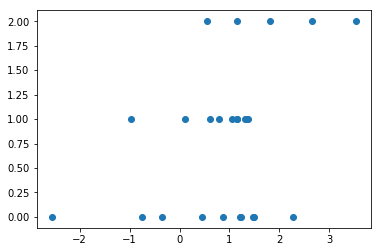

In [124]:
# create a toy dataset
np.random.seed(0)
np.set_printoptions(precision=6)
y = [np.random.randint(3) for i in range(25)]
X = (y + np.random.randn(25)).reshape(-1,1)
plt.scatter(X,y)

In [131]:
cv5_idx = list(StratifiedKFold(n_splits=5, shuffle=False, random_state=0).split(X,y))
# calculate the 5 accuracy values for the 5 test folds.
cross_val_score(LogisticRegression(random_state=123), X, y, cv=cv5_idx)

array([ 0.6,  0.4,  0.6,  0.2,  0.6])

In [132]:
from sklearn.model_selection import GridSearchCV

In [140]:
# The scores for the 5 folds are exactly the same as the ones from cross_val_score earlier.
gs = GridSearchCV(LogisticRegression(), {}, cv=cv5_idx, verbose=3).fit(X,y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV] ................................. , score=0.600000, total=   0.0s
[CV]  ................................................................
[CV] ................................. , score=0.400000, total=   0.0s
[CV]  ................................................................
[CV] ................................. , score=0.600000, total=   0.0s
[CV]  ................................................................
[CV] ................................. , score=0.200000, total=   0.0s
[CV]  ................................................................
[CV] ................................. , score=0.600000, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [144]:
# The result above is consistent with the average score computed the cross_val_score.
gs.best_score_

0.47999999999999998

In [145]:
cross_val_score(LogisticRegression(random_state=123), X, y, cv=cv5_idx).mean()

0.47999999999999998

<hr>

<br>
# Working with bigger data - online algorithms and out-of-core learning

In [146]:
import numpy as np
import re
from nltk.corpus import stopwords

In [149]:
def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized

<hr>
#### Note: Generators

Generators are iterators, but you can only iterate over them once. It's because they do not store all the values in memory, they generate the values on the fly:

In [155]:
# an iterable list comprehension
[x*x for x in range(3)]

[0, 1, 4]

In [152]:
# an iterable generator
(x*x for x in range(3))

<generator object <genexpr> at 0x7f6a10e253c0>

In [161]:
mygenerator = (x*x for x in range(3))
for i in mygenerator:
    print i

0
1
4


You cannot perform for i in mygenerator a second time since generators can only be used once: they calculate 0, then forget about it and calculate 1, and end calculating 4, one by one.
    

In [163]:
for i in mygenerator:
    print i

yield is a keyword that is used like return, except the function will return a generator.

In [177]:
def createGenerator():
    mylist = range(3)
    for i in mylist:
        yield i*i
        
mygenerator = createGenerator()
# mygenerator is an object
print mygenerator

<generator object createGenerator at 0x7f6a10e25780>


In [178]:
for i in mygenerator:
    print i

0
1
4


In [183]:
for i in mygenerator:
    print i

https://stackoverflow.com/questions/231767/what-does-the-yield-keyword-do-in-python
<hr>

In [288]:
def stream_docs(path):
    with open(path, 'r') as csv:
        next(csv)  # skip header
        for line in csv:
            text, label = line[:-3], int(line[-2])
            yield text, label

In [289]:
iterator = stream_docs('../movie_data.csv')

In [290]:
next(iterator)[:-3], next(iterator)[-2]


((),
 '"OK... so... I really like Kris Kristofferson and his usual easy going delivery of lines in his movies. Age has helped him with his soft spoken low energy style and he will steal a scene effortlessly. But, Disappearance is his misstep. Holy Moly, this was a bad movie! <br /><br />I must give kudos to the cinematography and and the actors, including Kris, for trying their darndest to make sense from this goofy, confusing story! None of it made sense and Kris probably didn\'t understand it either and he was just going through the motions hoping someone would come up to him and tell him what it was all about! <br /><br />I don\'t care that everyone on this movie was doing out of love for the project, or some such nonsense... I\'ve seen low budget movies that had a plot for goodness sake! This had none, zilcho, nada, zippo, empty of reason... a complete waste of good talent, scenery and celluloid! <br /><br />I rented this piece of garbage for a buck, and I want my money back! I wan

In [291]:
# creates small sized training sets for stochastic gradient desc
def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            text, label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None, None
    return docs, y

In [292]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier

In [293]:
vect = HashingVectorizer(decode_error='ignore',
                        n_features=2**21,
                        preprocessor=None,
                        tokenizer=tokenizer)

clf = SGDClassifier(loss='log', random_state=1, n_iter=1)

doc_stream = stream_docs(path='../movie_data.csv')

In [294]:
import pyprind
pbar = pyprind.ProgBar(45)

classes = np.array([0, 1])
for _ in range(45):
    X_train, y_train = get_minibatch(doc_stream, size=1000)
    if not X_train:
        break
    X_train = vect.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)
    pbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:06


In [295]:
X_test, y_test = get_minibatch(doc_stream, size=5000)
X_test = vect.transform(X_test)
clf.score(X_test, y_test)

0.86699999999999999

In [303]:
print 'Accuracy: %0.3f' %clf.score(X_test, y_test)

Accuracy: 0.883


In [302]:
# use the last 5000 documents to update the model
clf = clf.partial_fit(X_test, y_test)